In [1]:
#Montaje de Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Lectura y preprocesamiento de imágenes

In [2]:
#Importación de librerías y configuración
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Directorio de datasets:
#dataset_path = '/content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia/chest_xray/train'

# Directorio de datasets 2:
# Este dataset esta perfectamente balanceado entre las clases 'normal' y 'pneumonia' con la misma cantidad de imagenes pero combinando dos datasets distintos.
#dataset_path = '/content/drive/My Drive/proyecto2024_datasets/1_and_2_fusion_normal_pneumonia_same_amount/chest_xray/train'

# Directorio de datasets 3:
# Este dataset esta perfectamente balanceado entre las clases 'normal' y 'pneumonia' con la misma cantidad de imagenes del mismo dataset.
# Contenido: 234 in test - 1349 in train para ambas clases.
dataset_path = '/content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/train'

# Directorio de datasets 4:
# Este dataset esta perfectamente balanceado entre las clases 'normal' y 'pneumonia' con la misma cantidad de imagenes del mismo dataset.
# Contenido: La diferencia es que coloque mas imagenes en la carpeta de test (500 aprox en ambas clases).
# Luego en la carpeta de train esta compuesta por 1.000 imagenes en cada clase
#dataset_path = '/content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset-maselemintest/chest_xray/train'

# Tamaño al que se redimencionan las imágenes para que sean uniformes
IMG_SIZE = (512, 512)

# Función para cargar imágenes y convertirlas en arrays
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('L')  # Convertir a escala de grises
            img = img.resize(IMG_SIZE)  # Redimensionar las imágenes
            img_array = np.array(img).flatten()  # Convertir la imagen a un vector 1D
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f'Error al procesar {filename}: {e}')
    return images, labels

# Cargar imágenes de las carpetas 'NORMAL' y 'PNEUMONIA' asignando etiquetas (0 para NORMAL y 1 para PNEUMONIA).
normal_images, normal_labels = load_images_from_folder(os.path.join(dataset_path, 'NORMAL'), 0)
pneumonia_images, pneumonia_labels = load_images_from_folder(os.path.join(dataset_path, 'PNEUMONIA'), 1)

# Combinar las imágenes y las etiquetas
X = normal_images + pneumonia_images
y = normal_labels + pneumonia_labels

# Convertir a arrays de NumPy
X = np.array(X)
y = np.array(y)

# Separar en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)





##Expl.:

* `os`: Utilizado para manejar rutas de archivos y directorios.
* `numpy`: Usado para manejar arrays numéricos, esencial para la manipulación de datos.
* `PIL`: Biblioteca para abrir, manipular y guardar imágenes.
* `train_test_split`: Función de sklearn para dividir los datos en conjuntos de entrenamiento y validación.

`def load_images_from_folder(folder, label):`
* Objetivo: Cargar imágenes desde una carpeta, preprocesarlas y convertirlas en vectores.
* `Image.open(img_path).convert('L')`: Abre la imagen y la convierte a escala de grises (simplifica la imagen a un solo canal de color).
* `img.resize(IMG_SIZE)`: Redimensiona la imagen al tamaño especificado.
* `np.array(img).flatten()`: Convierte la imagen en un array NumPy y la aplana a un vector 1D. **Resultado**: Al convertir la imagen a un array de NumPy, se crea una representación de la imagen donde cada píxel tiene un valor asociado (generalmente entre 0 y 255 en el caso de imágenes en escala de grises). **Por ejemplo**, si la imagen tiene un tamaño de 256x256 pixeles, el array que se obtiene es de la forma (256, 256).
* `.flatten()`: convierte un array de más de una dimensión en un vector de una sola dimensión (1D). Los modelos de machine learning, como SVM, requieren que las entradas sean vectores de una sola dimensión. La imagen original es 2D (256x256), y al "aplanarla" con .flatten(), se convierte en un vector de 1D con 256 x 256 = 65.536 elementos.

El vector de una dimensión será lo que el modelo utilizará como entrada para hacer las predicciones.


#Entrenamiento y evaluación

In [3]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Modelo SVM
svm_model = SVC(kernel='linear', probability=True) #Crea un modelo de SVM (Support Vector Machine) con un kernel lineal. Modelo para clasificación
svm_model.fit(X_train, y_train) #Entrena el modelo con los datos de entrenamiento

# Predicciones originales en el conjunto de validación
y_pred = svm_model.predict(X_val)

# Evaluación del modelo sin ajustar el threshold
print("SVM Accuracy:", accuracy_score(y_val, y_pred)) #Calcula la precisión general del modelo (proporción de predicciones correctas)
print(classification_report(y_val, y_pred)) #informe detallado con presicion, recall, f1 score para ambas clases.


SVM Accuracy: 0.9648148148148148
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       281
           1       0.95      0.97      0.96       259

    accuracy                           0.96       540
   macro avg       0.96      0.97      0.96       540
weighted avg       0.97      0.96      0.96       540



In [4]:
# Predicciones con probabilidades en el conjunto de validación
y_pred_proba = svm_model.predict_proba(X_val)  # Devuelve las probabilidades para cada clase

# Mostrar las primeras predicciones con sus porcentajes de confianza
for i in range(5):  # Muestra solo las primeras 5 como ejemplo
    print(f"Predicción: {y_pred[i]}, Probabilidad de clase 0 (normal): {y_pred_proba[i][0]:.2f}, Probabilidad de clase 1 (neumonía): {y_pred_proba[i][1]:.2f}")

Predicción: 0, Probabilidad de clase 0 (normal): 0.99, Probabilidad de clase 1 (neumonía): 0.01
Predicción: 0, Probabilidad de clase 0 (normal): 0.99, Probabilidad de clase 1 (neumonía): 0.01
Predicción: 0, Probabilidad de clase 0 (normal): 1.00, Probabilidad de clase 1 (neumonía): 0.00
Predicción: 0, Probabilidad de clase 0 (normal): 0.87, Probabilidad de clase 1 (neumonía): 0.13
Predicción: 0, Probabilidad de clase 0 (normal): 1.00, Probabilidad de clase 1 (neumonía): 0.00


## Expl.:

Estas son las métricas de precisión, recall, F1-score y accuracy sin ajustar el threshold (umbral).

`svm_model = SVC(kernel='linear')` crea un modelo de **Máquinas de Soporte Vectorial (SVM)** en Scikit-Learn utilizando un **kernel lineal**.

`SVC`: Es la clase para crear un clasificador de SVM en Scikit-Learn. `SVC` significa "Support Vector Classifier" (Clasificador de Vectores de Soporte).

`kernel='linear'`: El parámetro `kernel` especifica el tipo de función que usará SVM para separar los datos. En este caso, se utiliza un kernel lineal, lo que significa que SVM intentará encontrar una línea recta (en 2D) que separe las clases en los datos.

Cuando se entrena el modelo con los datos, el algoritmo de SVM busca la mejor línea o hiperplano que maximice la margen entre las diferentes clases.

`predict_proba(X_val)` devuelve una lista de probabilidades para cada clase. Para cada imagen, `y_pred_proba[i][0]` es la probabilidad de la clase "normal" (0), `y y_pred_proba[i][1]` es la probabilidad de la clase "neumonía" (1).

**Impresión de resultados:** el ciclo `for` al final muestra algunas de las predicciones junto con sus porcentajes de confianza.


# Pruebas en el conjunto de test


In [5]:
# Ruta de la carpeta de test del dataset 1
#test_dir = '/content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia/chest_xray/test'

# Ruta de la carpeta de test del dataset 2
#test_dir = '/content/drive/My Drive/proyecto2024_datasets/1_and_2_fusion_normal_pneumonia_same_amount/chest_xray/test'

# Ruta de la carpeta de test del dataset 3
test_dir = '/content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/test'

# Ruta de la carpeta de test del dataset 4:
#test_dir = '/content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset-maselemintest/chest_xray/test'


# Cargar las imágenes de la carpeta de test
test_normal_images, test_normal_labels = load_images_from_folder(os.path.join(test_dir, 'NORMAL'), 0)
test_pneumonia_images, test_pneumonia_labels = load_images_from_folder(os.path.join(test_dir, 'PNEUMONIA'), 1)

# Combinar las imágenes y etiquetas de test
X_test = test_normal_images + test_pneumonia_images
y_test = test_normal_labels + test_pneumonia_labels

# Convertir a arrays de NumPy
X_test = np.array(X_test)
y_test = np.array(y_test)

# Realizar predicciones sobre el conjunto de test
y_test_pred = svm_model.predict(X_test)

# Evaluar el rendimiento del modelo sobre el conjunto de test
print("SVM Accuracy (Test):", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


SVM Accuracy (Test): 0.7222222222222222
              precision    recall  f1-score   support

           0       0.97      0.46      0.62       234
           1       0.65      0.99      0.78       234

    accuracy                           0.72       468
   macro avg       0.81      0.72      0.70       468
weighted avg       0.81      0.72      0.70       468



# Pruebas manuales

In [6]:
image_path = '/content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/test/NORMAL/IM-0097-0001.jpeg'

def preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('L')
        img = img.resize(IMG_SIZE)
        img_array = np.array(img).flatten()
        return np.array([img_array])
    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return None

image_to_predict = preprocess_image(image_path)


In [7]:
if image_to_predict is not None:
    prediction = svm_model.predict(image_to_predict)
    label = "NORMAL" if prediction == 0 else "PNEUMONIA"
    print(f"La imagen seleccionada ha sido clasificada como: {label}")
else:
    print("No se pudo procesar la imagen.")


La imagen seleccionada ha sido clasificada como: NORMAL


# Image Viewing

Visualización de la primera imagen de la clase X

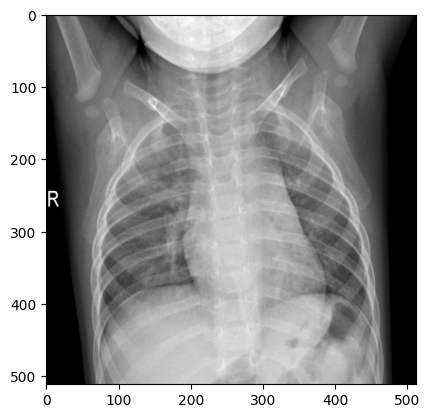

In [8]:
#toma la primera imagen del dataset, la reorganiza en una matriz de 512x512 píxeles y luego la visualiza en una escala de grises utilizando matplotlib
import matplotlib.pyplot as plt
img = X[0].reshape(512, 512)
plt.imshow(img, cmap='gray')
plt.show()

Primeras 50 imágenes del dataset X

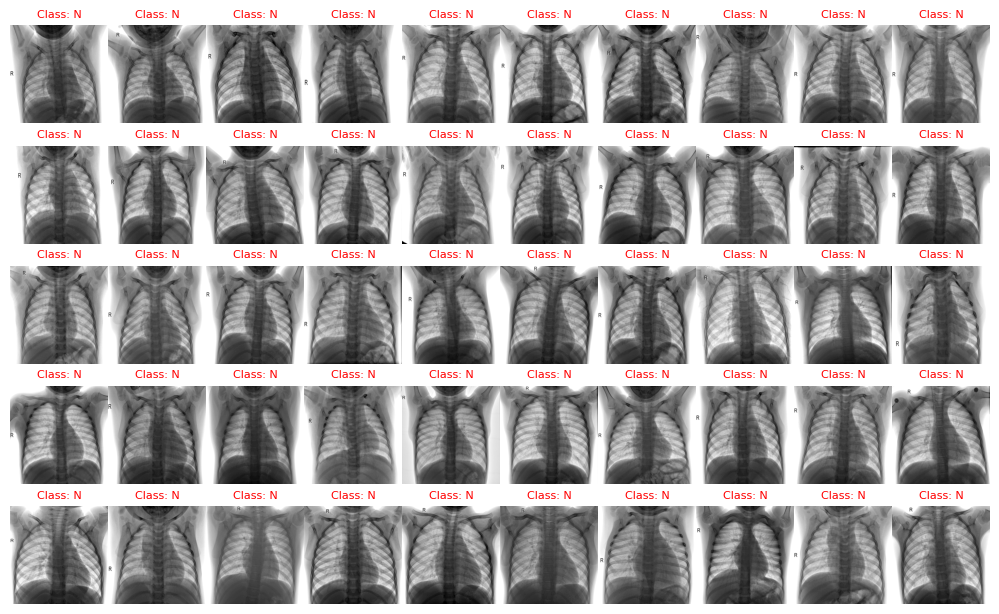

In [9]:
import matplotlib.pyplot as plt

def plot_digit(image_data, label):
    image = image_data.reshape(512, 512)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    # Título con clase (N para Normal y P para Pneumonia)
    plt.title(f"Class: {'N' if label == 0 else 'P'}", fontsize=8, color='red')

plt.figure(figsize=(10, 5))  # Tamaño ajustado para reducir el espacio

# Mostrar las primeras 50 imágenes con sus etiquetas
for idx, (image_data, label) in enumerate(zip(X[:50], y[:50])):
    plt.subplot(5, 10, idx + 1)  # Cuadrícula de 5 filas y 10 columnas
    plot_digit(image_data, label)

# espaciado entre las imágenes
plt.subplots_adjust(left=0.01, right=0.99, top=1.2, bottom=0.01, wspace=0, hspace=0.05)

plt.show()




#Cross-Validaton

In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_train, y_train, cv=3, scoring="accuracy")
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.95416667 0.95827538 0.9596662 ]
Mean Accuracy: 0.9573694174007109


# Evaluación de Presicion, Recall y Threshold

*Reimpresión de métricas sin ajustar el threshold*

In [11]:
# Reutilización de las predicciones para imprimir las métricas adicionales
print("\nRe-imprimiendo el reporte de clasificación:")
print(classification_report(y_val, y_pred))



Re-imprimiendo el reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       281
           1       0.95      0.97      0.96       259

    accuracy                           0.96       540
   macro avg       0.96      0.97      0.96       540
weighted avg       0.97      0.96      0.96       540



##Cálculos y gráfica

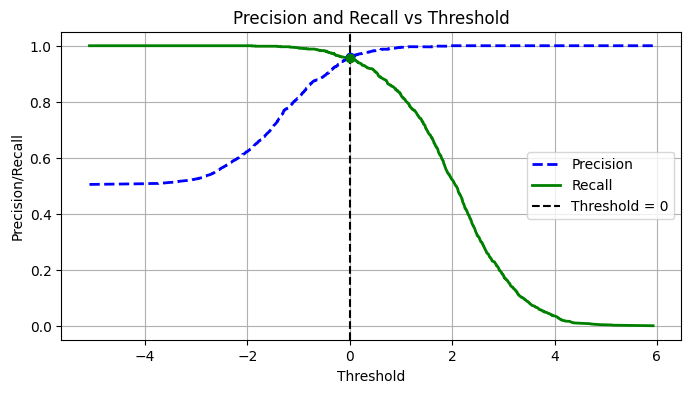

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener los scores de decisión usando decision_function() con validación cruzada
y_scores = cross_val_predict(svm_model, X_train, y_train, cv=3, method="decision_function")

# Calcular precisión, recall y los umbrales
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

# Definir el umbral a visualizar
threshold = 0

# Crear el gráfico de precisión y recall vs umbral
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

# Línea vertical para el umbral actual
plt.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold = {threshold}')

# Marcar los valores de precisión y recall en el umbral seleccionado
idx = (thresholds >= threshold).argmax()  # Encuentra el índice del umbral seleccionado
plt.plot(thresholds[idx], precisions[idx], "bo")  # Punto en Precision
plt.plot(thresholds[idx], recalls[idx], "go")     # Punto en Recall

# Configurar el gráfico: límites, leyenda, etiquetas y grilla
plt.grid()
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend(loc="center right")
plt.title("Precision and Recall vs Threshold")

plt.show()


##Hacer predicciones con un threshold ajustado



In [13]:
# Obtener los scores de decisión para el conjunto de validación
y_val_scores = svm_model.decision_function(X_val)

# Elegir un nuevo threshold
new_threshold = 0.5

# Generar predicciones ajustando el threshold manualmente
y_pred_threshold = (y_val_scores > new_threshold).astype(int)

# Evaluar con el nuevo threshold
print(classification_report(y_val, y_pred_threshold))

#Este proceso permite optimizar el rendimiento del modelo para los casos en los que interese más el recall (detección de neumonía) o la precision (evitar falsos positivos).

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       281
           1       0.97      0.94      0.95       259

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



Se puede observar como sube la precision dependiendo la clase y baja el recall con el nuevo valor de threshold definido. El valor de f1-score baja ya que el threshold no es el mas equilibrado para ambas clases.

##Expl.:

`y_val_scores = svm_model.decision_function(X_val)`
 Utiliza el modelo ya entrenado (`svm_model`) para generar las puntuaciones de decisión sobre el conjunto de validación `X_val`.

## Comparativa de metricas antes y después del ajuste del threshold

In [14]:
from sklearn.metrics import classification_report

report_sin_umbral = classification_report(y_val, y_pred, output_dict=True)
report_con_umbral = classification_report(y_val, y_pred_threshold, output_dict=True)

print("Reporte de clasificación sin umbral ajustado:")
print("------------------------------------------------")
print(f"Precisión (0): {report_sin_umbral['0']['precision']:.4f}")
print(f"Recall (0): {report_sin_umbral['0']['recall']:.4f}")
print(f"F1 Score (0): {report_sin_umbral['0']['f1-score']:.4f}\n")
print(f"Precisión (1): {report_sin_umbral['1']['precision']:.4f}")
print(f"Recall (1): {report_sin_umbral['1']['recall']:.4f}")
print(f"F1 Score (1): {report_sin_umbral['1']['f1-score']:.4f}")
print(f"Accuracy: {report_sin_umbral['accuracy']:.4f}")

print("\nReporte de clasificación con umbral ajustado:")
print("------------------------------------------------")
print(f"Precisión (0): {report_con_umbral['0']['precision']:.4f}")
print(f"Recall (0): {report_con_umbral['0']['recall']:.4f}")
print(f"F1 Score (0): {report_con_umbral['0']['f1-score']:.4f}\n")
print(f"Precisión (1): {report_con_umbral['1']['precision']:.4f}")
print(f"Recall (1): {report_con_umbral['1']['recall']:.4f}")
print(f"F1 Score (1): {report_con_umbral['1']['f1-score']:.4f}")
print(f"Accuracy: {report_con_umbral['accuracy']:.4f}")


Reporte de clasificación sin umbral ajustado:
------------------------------------------------
Precisión (0): 0.9746
Recall (0): 0.9573
F1 Score (0): 0.9659

Precisión (1): 0.9545
Recall (1): 0.9730
F1 Score (1): 0.9637
Accuracy: 0.9648

Reporte de clasificación con umbral ajustado:
------------------------------------------------
Precisión (0): 0.9479
Recall (0): 0.9715
F1 Score (0): 0.9596

Precisión (1): 0.9683
Recall (1): 0.9421
F1 Score (1): 0.9550
Accuracy: 0.9574


#Detectar imágenes duplicadas usando hashing

In [15]:
import os
import hashlib
from collections import defaultdict

# Función para calcular el hash de una imagen
def hash_image(image_path):
    with open(image_path, 'rb') as img_file:
        img_hash = hashlib.md5(img_file.read()).hexdigest()
    return img_hash

# Función para buscar imágenes duplicadas en un directorio
def find_duplicates_in_directory(directory):
    hashes = defaultdict(list)  # Diccionario para almacenar hashes y sus rutas
    for foldername, _, filenames in os.walk(directory):
        for filename in filenames:
            img_path = os.path.join(foldername, filename)
            img_hash = hash_image(img_path)
            hashes[img_hash].append(img_path)

    duplicates = {k: v for k, v in hashes.items() if len(v) > 1}  # Filtrar duplicados
    return duplicates

# Ruta del directorio donde estan las imagenes
dataset_path = '/content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/train'
duplicates = find_duplicates_in_directory(dataset_path)

# Mostrar las imágenes duplicadas
for img_hash, paths in duplicates.items():
    print(f"Hash: {img_hash}")
    for path in paths:
        print(f" - {path}")


Hash: c7a269a84528269d8f34e6bceeb4d880
 - /content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/train/PNEUMONIA/person30_bacteria_157.jpeg
 - /content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/train/PNEUMONIA/person30_bacteria_156.jpeg
Hash: 23d698733d4709babc2bf0b40ea67cf4
 - /content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/train/PNEUMONIA/person357_virus_735.jpeg
 - /content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/train/PNEUMONIA/person357_virus_734.jpeg
Hash: 9355430a9242aae9221a95db1f856164
 - /content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/train/PNEUMONIA/person401_virus_797.jpeg
 - /content/drive/My Drive/proyecto2024_datasets/1.chest-xray-pneumonia-misma-cantidad-mismo-dataset/chest_xray/tr

## Aclaraciones importantes

En el análisis del dataset se utilizó una función para detectar imágenes duplicadas, con el objetivo de demostrar que existen datos redundantes que afectan negativamente el entrenamiento del modelo. La presencia de duplicados y de posibles errores de etiquetado compromete la calidad del dataset, ya que induce al modelo a aprender patrones que no generalizan correctamente, perjudicando su rendimiento en fases de evaluación y test. Esto evidencia que el dataset no es completamente confiable y puede impactar los resultados de predicción en un entorno real, especialmente en tareas críticas como el diagnóstico médico.

# Curva ROC y AUC

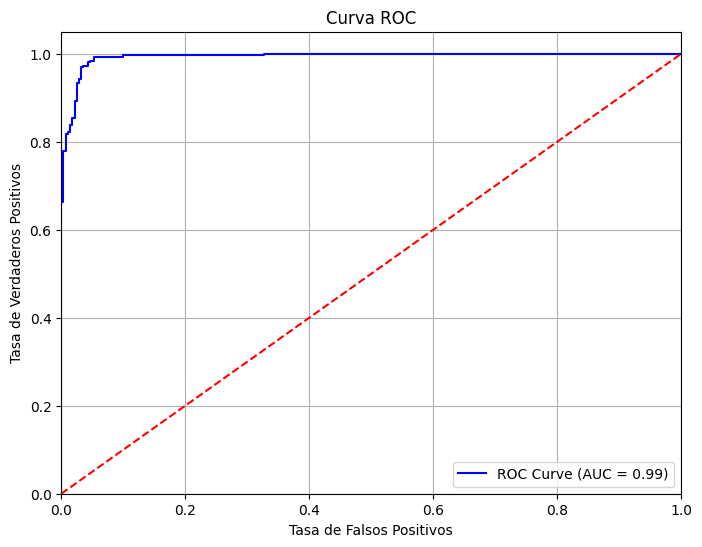

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_val_scores = svm_model.decision_function(X_val) da la distancia de cada punto de datos a la frontera de decisión.

# Calcular los valores de la curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_scores) # devuelve las tasas de falsos positivos (FPR) y verdaderos positivos (TPR) para varios umbrales.

#  Calcular el AUC (área bajo la curva ROC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


##Expl.:

Un AUC de 0.99 sugiere que el modelo es extremadamente bueno para distinguir entre las dos clases

Esto significa que hay una probabilidad del 99% de que el modelo asignará un score más alto a un caso positivo (neumonía) que a un caso negativo (normal) al seleccionar aleatoriamente un caso positivo y uno negativo.

Alta Precisión: El modelo tiene una alta precisión en la clasificación, lo que implica que tiene un bajo número de falsos positivos y falsos negativos.

Confiabilidad: confiar en las predicciones del modelo, especialmente si el objetivo es detectar una condición crítica como la neumonía.


#Visualización y conteo de aciertos y errores

Mostrar qué imágenes el modelo clasifica como "Normal" o "Pneumonia", así como la etiqueta verdadera de cada imagen en el conjunto de test

In [17]:
# Etiquetas
label_map = {0: 'Normal', 1: 'Pneumonia'}

# Mostrar resultados para cada imagen en el conjunto de test
for i in range(len(X_test)):
    prediccion = label_map[y_test_pred[i]]  # Prediccion del modelo
    etiqueta_real = label_map[y_test[i]]    # Etiqueta verdadera
    print(f"Imagen {i+1}: Predicción del modelo = {prediccion}, Etiqueta verdadera = {etiqueta_real}")


Imagen 1: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 2: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 3: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 4: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 5: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 6: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 7: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 8: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 9: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 10: Predicción del modelo = Normal, Etiqueta verdadera = Normal
Imagen 11: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 12: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 13: Predicción del modelo = Pneumonia, Etiqueta verdadera = Normal
Imagen 14: Predicción del modelo = Pneumonia, Etiq

In [18]:
# Comparar predicciones con etiquetas reales
aciertos = (y_test_pred == y_test).sum()
errores = (y_test_pred != y_test).sum()

# Total de imagenes en el conjunto de test
total = len(y_test)

porcentaje_aciertos = (aciertos / total) * 100
porcentaje_errores = (errores / total) * 100

print(f"Aciertos: {aciertos} de {total} ({porcentaje_aciertos:.2f}%)")
print(f"Errores: {errores} de {total} ({porcentaje_errores:.2f}%)")


Aciertos: 338 de 468 (72.22%)
Errores: 130 de 468 (27.78%)


#Guardar el modelo entrenado

In [19]:
import joblib
from google.colab import files

# Guardar el modelo entrenado en un archivo con el nombre del dataset_path utilizado
#joblib.dump(svm_model, 'trained_model_svm_pneumonia.pkl')

#files.download('trained_model_svm_pneumonia.pkl')

#El formato .pkl es un formato de serialización de Python que permite guardar objetos Python en disco.


Actualmente no es posible subir el modelo entrenado a Hugging Face para utilizarlo remotamente desde la app web ya que no es el formato ideal para compartir modelos en Hugging Face.

Hugging Face tiene su propio formato para almacenar modelos y recomienda guardar los modelos en formato compatible con PyTorch o TensorFlow.

Migrar el modelo actualmente desarrollado a TensorFlow o Keras implicaría reestructurar varias partes del código, ya que el proceso de modelado, entrenamiento y evaluación es diferente al de scikit-learn.